## Chapter 5 from Bjornstad et al. (2018): Seasonality


### Environmental drivers

We can illustrate various types of seasonality using four diseases in Pennsylvania contained in the `paili`, `palymes`, `pagiard` and `pameasle` datasets. We first write a simple function to extract and plot weekly average incidence (and standard errors) through the year from time series. Weekly incidence data occasionally has a 53 reporting week (because years are 52.14 weeks, and leap-years are 52.28 weeks). The function omits these extras.

In [1]:
library(epimdr)
data(paili)
data(palymes)
data(pagiard)
data(pameasle)

Loading required package: shiny
Loading required package: deSolve
Loading required package: phaseR
Loading required package: polspline


In [2]:
ppp <- function(wk, x){
    require(plotrix)
    x = x[wk<53]
    wk = wk[wk<53]
    ses = sapply(split(x, wk), mean, na.rm = TRUE)
    sesdv = sapply(split(x, wk), sd, na.rm = TRUE)/sqrt(length(split(x, wk)))
    plotCI(x = c(1:52), y = ses, ui = ses+sesdv, li = ses-sesdv, xlab = "Week", ylab = "Incidence")
}

We apply the function to reported incidence of Lyme’s disease, giardiosis, measles and mortality from influenza-like illness (ILI) (Fig. \[fig:c5-paseas\]):

Loading required package: plotrix


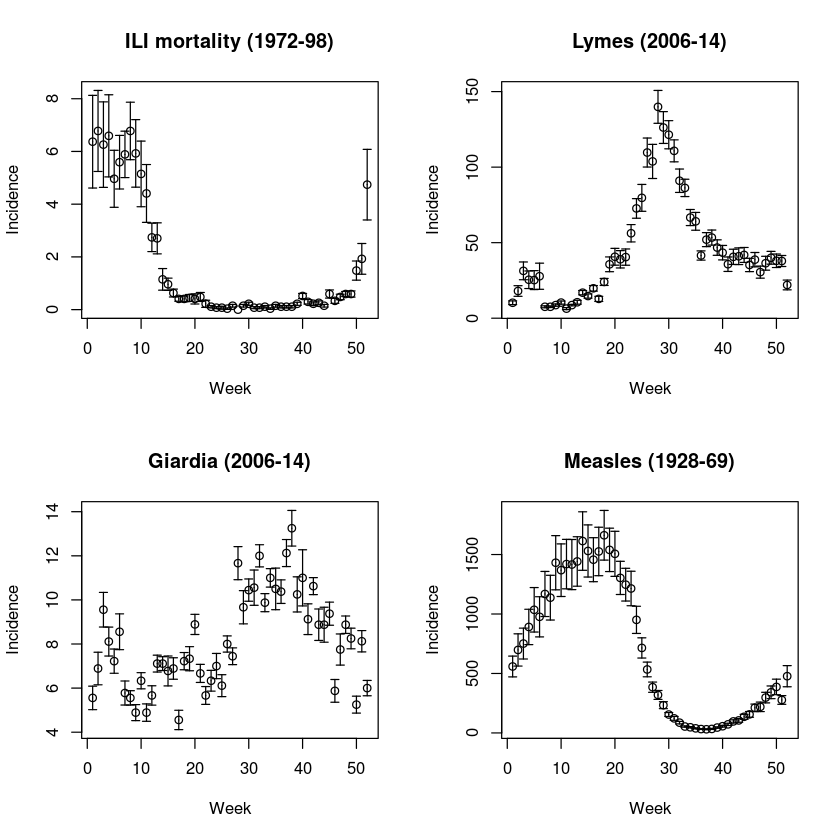

In [3]:
par(mfrow = c(2, 2))  #A four panel plot
ppp(paili[, "WEEK"], paili[, "PENNSYLVANIA"])
title("ILI mortality (1972-98)")
ppp(palymes[, "WEEK"], palymes[, "PENNSYLVANIA"])
title("Lymes (2006-14)")
ppp(pagiard[, "WEEK"], pagiard[, "PENNSYLVANIA"])
title("Giardia (2006-14)")
ppp(pameasle[, "WEEK"], pameasle[, "PENNSYLVANIA"])
title("Measles (1928-69)")

### The seasonally-forced SEIR model

To study the effect of seasonality in transmission we modify the SEIR model. We first define the gradient functions for the ‘undriven’ system:

In [4]:
seirmod = function(t, y, parms) {
    S = y[1]
    E = y[2]
    I = y[3]
    R = y[4]
    
    mu = parms["mu"]
    N = parms["N"]
    beta = parms["beta"]
    sigma = parms["sigma"]
    gamma = parms["gamma"]
    
    dS = mu * (N - S) - beta * S * I/N
    dE = beta * S * I/N - (mu + sigma) * E
    dI = sigma * E - (mu + gamma) * I
    dR = gamma * I - mu * R
    res = c(dS, dE, dI, dR)
    list(res)
}

We simulate 10-years of dynamics. The seasonally-forced SEIR model has been very successfully applied to understand the dynamics of measles (and other immunizing childhood infections). To simulate measles-like dynamics we assume a latent period of 8 days and an infectious period of 5 days. We assume the initial host population to be $0.1\%$ infectious, $6\%$ susceptibles and the rest immune; The $R_0$ of measles is typically quoted in the 13 to 20 range, which means that the equilibrium fraction of susceptibles is somewhere around $5\%$. For simplicity we assume a host life-span of 50 years and set $N=1$ to model the fraction in each compartment.

In [5]:
require(deSolve)
times  = seq(0, 10, by=1/120)
paras  = c(mu = 1/50, N = 1, beta =  1000, 
     sigma = 365/8, gamma = 365/5)
start = c(S = 0.06, E = 0, I = 0.001, R = 0.939)

As discussed previously, the $R_0$ for this system – assuming disease induced mortality is negligible – is $ \frac{\sigma}{\sigma +\mu} \frac{\beta}{\gamma+\mu}$. We can verify that our choice of $\beta$ places $R_0$ in the ‘measles-like’ range. We use `expression` to define the equation for $R_0$. We use `with(as.list(…))` to evaluate the expression using the definitions in the `paras`-vector.

In [6]:
R0 = expression(sigma/(sigma + mu) * beta/(gamma + mu))
with(as.list(paras), eval(R0))

[1] 13.68888

We can integrate the ODEs and plot the time series in time and the phase plane (fig. \[fig:seir\]). As is the case of the SIR model, the unforced SEIR model predicts dampened oscillations toward the endemic equilibrium.

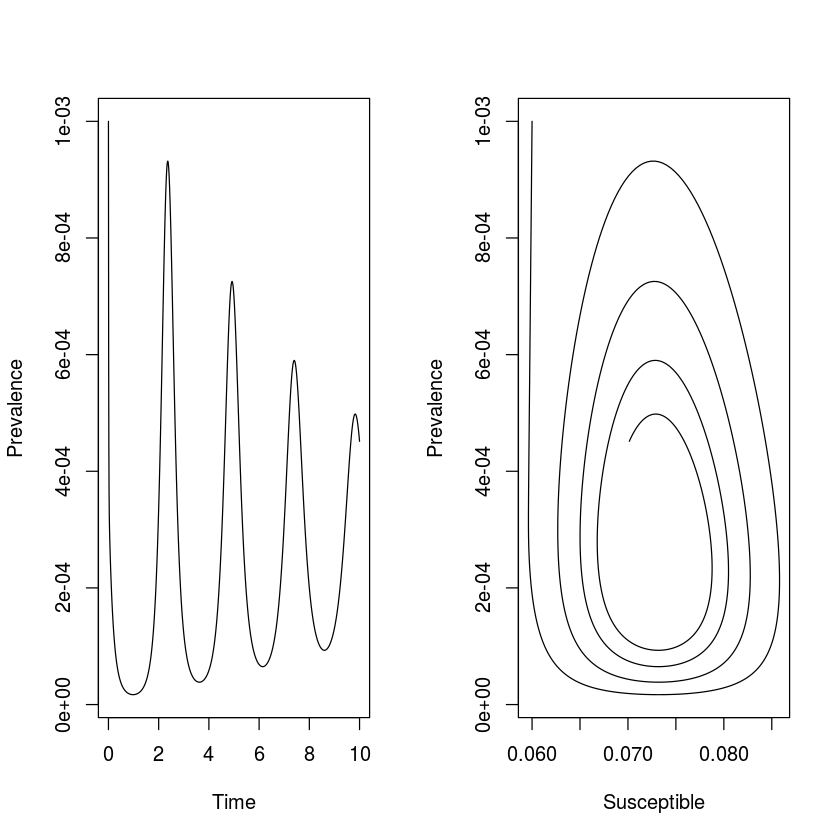

In [7]:
out = as.data.frame(ode(start, times, seirmod, paras))
par(mfrow = c(1,2))  #Two plots side by side 
plot(times, out$I, ylab = "Prevalence", 
     xlab = "Time", type = "l")
plot(out$S, out$I, ylab = "Prevalence", 
     xlab = "Susceptible", type = "l")

Seasonality in $\beta$
----------------------

The predicted dampend oscillations toward an equilibrium is at odds with the recurrent outbreaks seen in many immunizing infections. Sustained oscillations require either additional predictable seasonal drivers or stochasticity. An important driver in human childhood infections is seasonality in contact rates because of aggregation of children during the school term . For simplicity we can analyze the consequences of seasonality by assuming sinusoidal forcing on the transmission rate according to $\beta(t) =  \beta_0 (1 + \beta_1 cos(2 \pi t))$. The mean transmission rate is $\beta_0$ but the realized transmission varies cyclically with a period of one time unit, and the magnitude of the seasonal variation is controlled by the parameter $\beta_1$. The modified gradient function is:

In [8]:
seirmod2 = function(t, y, parms){
  S = y[1]
  E = y[2]
  I = y[3]
  R = y[4]
  with(as.list(parms),{
     dS = mu * (N  - S)  - beta0 * (1+beta1 * 
        cos(2 * pi * t)) * S * I / N
     dE = beta0 * (1 + beta1 * cos(2*pi * t)) * 
        S * I / N - (mu + sigma) * E
     dI = sigma * E - (mu + gamma) * I
     dR = gamma * I - mu * R
     res = c(dS, dE, dI, dR)
     list(res)
   })
} 

With no seasonality the model predicts dampened oscillation, with moderate seasonality the prediction is low-amplitude annual outbreaks. However, as seasonality increases (to $\beta_1 = 0.2$, say) we start seeing some surprising consequences of the seasonal forcing: the appearance of harmonic resonance between the internal cyclic dynamics of the SEIR clockwork and the annual seasonal forcing function.

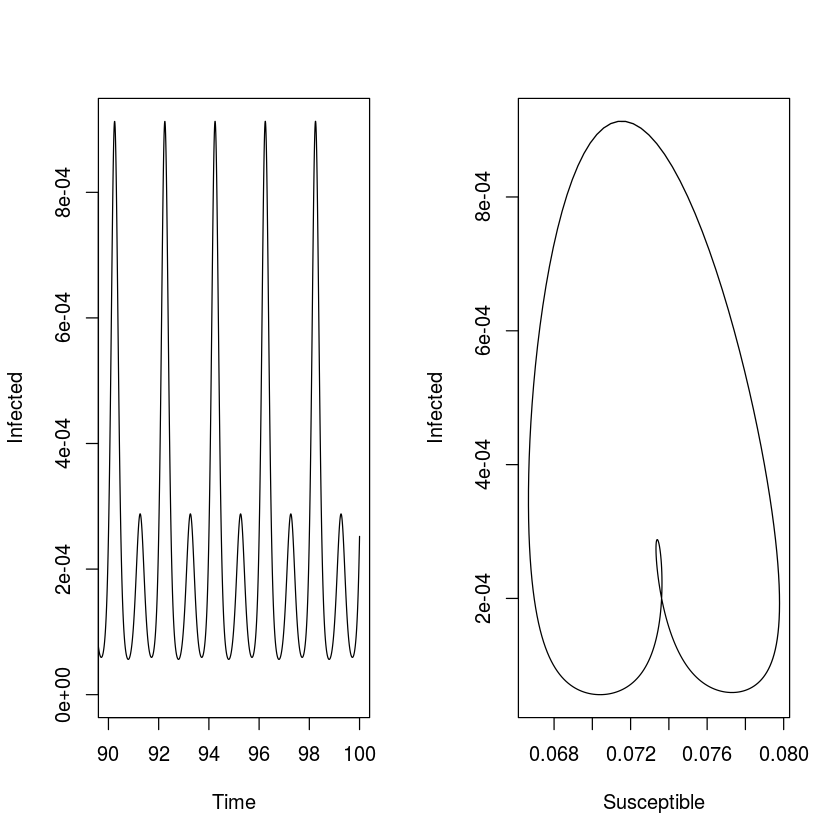

In [9]:
times  = seq(0, 100, by=1/120)
paras  = c(mu = 1/50, N = 1, beta0 = 1000, beta1 = 0.2, 
     sigma = 365/8, gamma = 365/5)
start = c(S = 0.06, E = 0, I = 0.001, R = 0.939)
out = as.data.frame(ode(start, times, seirmod2, paras))
par(mfrow = c(1,2)) #Side-by-side plot
plot(times, out$I, ylab="Infected", xlab="Time", 
     xlim = c(90, 100), ylim = c(0, 
     max(out$I[11001:12000])), type = "l")
plot(out$S[11001:12000], out$I[11001:12000], 
     ylab = "Infected", xlab = "Susceptible", type = "l")

The emergent pattern of recurrence in the forced SEIR is the result of an interaction between the internal periodic clockwork (the ‘damping period’) of the SEIR flow and the externally-imposed periodic forcing. The damping period is the focus of chapter \[chap:c10\], however we can use the results previewed in \[sec:c1peri\]: When working with a continuous-time ODE model which results in cyclic behavior like the SEIR model, the dominant eigenvalues of the the [](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) – when evaluated at the equilibrium – are a conjugate pair of complex numbers ($a \pm b \imath$) that determines the period of the cycle according to $2 \pi / b$.

The endemic equilibrium of the SEIR model (ignoring the absorbing R compartment $R^* = 1^*-S^*-E^*-I^*$) is $S^* = 1/R_0$, $E^*= (\mu+\gamma) I^*/\sigma$ and $I^* = \mu (1-1/R_0) R_0 / \beta$:

In [10]:
mu = paras["mu"]
N = paras["N"]
beta0 = paras["beta0"]
beta1 = paras["beta1"]
sigma = paras["sigma"]
gamma = paras["gamma"]
R0 = sigma/(sigma + mu) * beta0/(gamma + mu)
# Equilibria
Sstar = 1/R0
Istar = mu * (1 - 1/R0) * R0/beta0
Estar = (mu + gamma) * Istar/sigma
eq = list(S = Sstar, E = Estar, I = Istar)

We next use Rs inbuilt `D`-function to carry out symbolic differentiation, to generate and evaluate the Jacobian matrix (ignoring the absorbing R compartment):

In [11]:
dS = expression(mu * (N  - S)  - beta0 * S * I / N)
dE = expression(beta0 * S * I / N - (mu + sigma) * E)
dI = expression(sigma*E - (mu + gamma) * I)
#Elements of Jacobian
j11 = D(dS, "S");  j12 = D(dS, "E");  j13 = D(dS, "I")
j21 = D(dE, "S");  j22 = D(dE, "E");  j23 = D(dE, "I")
j31 = D(dI, "S");  j32 = D(dI, "E"); j33 = D(dI, "I")
#Jacobian
J = with(eq,
matrix(c(eval(j11),eval(j12),eval(j13),
   eval(j21),eval(j22), eval(j23),
   eval(j31),eval(j32), eval(j33)), 
    nrow=3, byrow=TRUE))

We finally calculate the eigenvalues. The dominant pair of complex conjugates are at the 2nd and 3rd place in the vector of eigenvalues. The resultant resonant period is:

In [12]:
round(eigen(J)$values, 3)
2 * pi/(Im(eigen(J)$values[2]))

[1] -118.725+0.000i   -0.107+2.667i   -0.107-2.667i

[1] 2.355891

So the recurrent biennial epidemics are sustained because the internal epidemic clock-work cycles with a period of 2.3 year, but it is forced at an annual time scale, so as a ‘compromise’ the epidemics are locked on to the annual clock, but with alternating major and minor epidemics such as seen, for example, in pre-vaccination measles in New York 1944-58 and London 1950-1965.

### Bifurcation analysis

We can make a more comprehensive summary of the consequences of seasonality on the SEIR-flow using a bifurcation analysis: a systematic search across a range of $\beta_1$ values. For annually forced models we study the dynamics by ‘strobing’ the system once each year. To study the long-term (asymptotic) dynamics we discard the initial transient part of the simulation. In the below we hence use one data point per year for the last 42 years of simulation – which the `sel` variable flags – so that an annual cycle produces a single value (so will a fixed-point equilibrium), biannual cycles two values, etc. The resultant bifurcation plot shows when annual epidemics gives way to biannual cycles and finally chaotic dynamics as seasonality increases. The irregular dynamics with strong seasonality comes about because there is no simple resonant compromise between the internal clock and the external forcing function. We may think of it as ‘resonance’ giving place to ‘dissonance’ in the dynamical system. That stronger seasonality pushes measles from regular to irregular epidemics has been predicted by the theoretical literature and is supported by an empirical comparison of measles in pre-vaccination UK *versus* US.

We define initial conditions and the sequence of parameter values to be considered for $\beta_1$ and then do the numerical integration for each parameter set:

In [13]:
times = seq(0, 100, by = 1/120)
start = c(S = 0.06, E = 0, I = 0.001, R = 0.939)
beta1 = seq(0,0.25, length=101)
#Matrix to store infecteds
Imat = matrix(NA, ncol = 12001, nrow = 101)
#Loop over beta1's
for(i in 1:101){
     paras  = c(mu = 1/50, N = 1, beta0 = 1000, 
        beta1 = beta1[i], sigma = 365/8, gamma = 365/5)
     out = as.data.frame(ode(start, times, 
        seirmod2, paras))
     Imat[i,] = out$I
}

For the visualization we select one observation per year for the last 42 years of simulation and plot the values against the associated $\beta_1$ values (Fig. \[fig:bifplot\]).

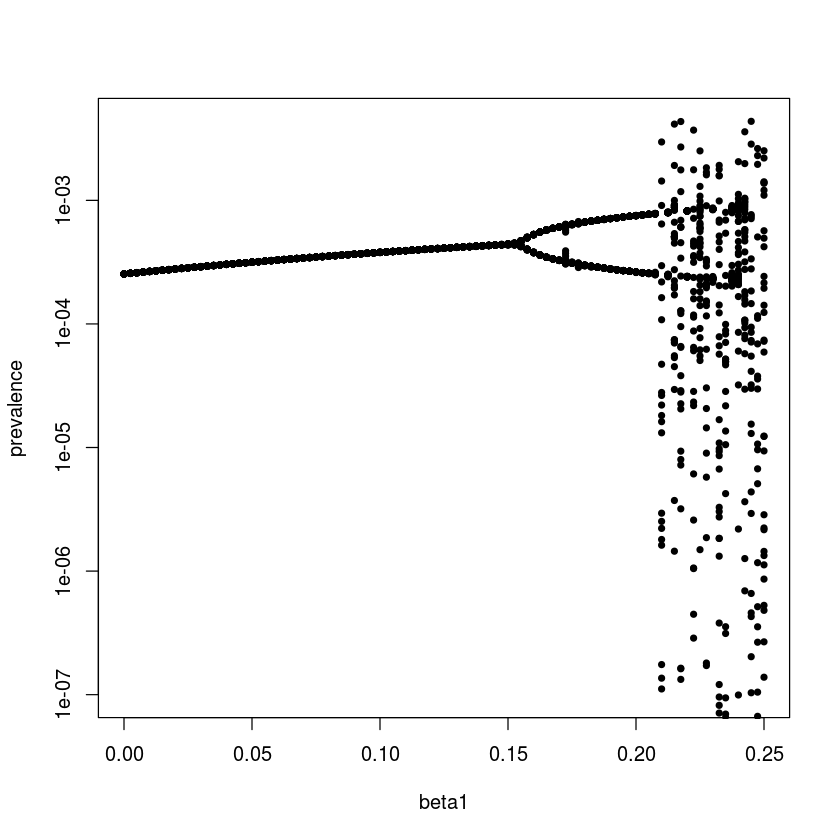

In [14]:
sel = seq(7001, 12000, by = 120)  
plot(NA, xlim = range(beta1), ylim = c(1E-7, 
     max(Imat[,sel])), log = "y", xlab = "beta1",
     ylab = "prevalence")
for(i in 1:101){
       points(rep(beta1[i], length(sel)), 
          Imat[i, sel], pch=20)
}

### Stroboscopic section

It is interesting to integrate the model with parameters leading to chaotic dynamics for a very long time (in this case for 10,000 years) to better understand/visualize the meaning of quasi-periodic chaos. The following shows a time series of prevalence and the dynamics in the S-I phase plane strobed at the annual time scale – the annual ‘stroboscopic section’ of the S-I plane. The time series is erratic, but the paired S-I series trace out a very intricate pattern. The four-armed shape corresponds to the propensity of the chaotic pattern to adhere to a wobbly (‘quasiperiodic’) 4-year recurrence. We will revisit on this attractor and its role in facilitating ‘chaotic stochasticity’ and ‘stochastic resonance’ in disease dynamics later.

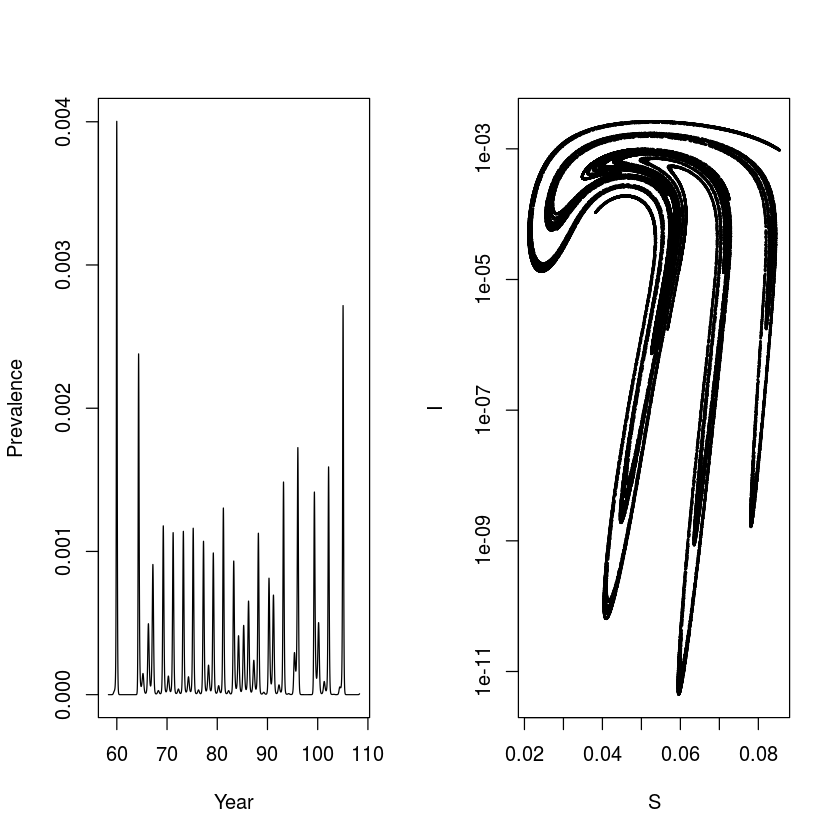

In [15]:
times = seq(0, 100000, by = 1/120)
start = c(S = 0.06, E = 0, I = 0.001, R = 0.939)
paras  = c(mu = 1/50, N = 1, beta0 = 1800, beta1=0.28, 
     sigma = 35.84, gamma = 100)
out = as.data.frame(ode(start, times,seirmod2, paras))
sel = seq(7001, 12000000, by = 120)  
par(mfrow = c(1,2))
plot(out$time[7001:13001], out$I[7001:13001], 
     type = "l", xlab = "Year", ylab = "Prevalence")
plot(out$S[sel], out$I[sel], type = "p", xlab = "S", 
     ylab = "I", log = "y", pch = 20, cex = 0.25)

### Susceptible recruitment

The patterns of recurrent epidemics is also shaped by other characteristics of the host and pathogen. studied how susceptible recruitment affects dynamics of the seasonally forced SEIR model by doing a bifurcation analysis over $\mu$. As concluded by , reduced susceptible recruitment in the seasonally-forced SEIR model leads to a cascade from annual to biennial to coexisting annual and complex attractors[2]. To trace out the coexisting attractors it is necessary to use multiple starting conditions because each attractor will have its own ‘basin of attraction’. We do this by looping forwards and backwards over $\mu$ using the final values of the previous simulation as initial conditions for the next.

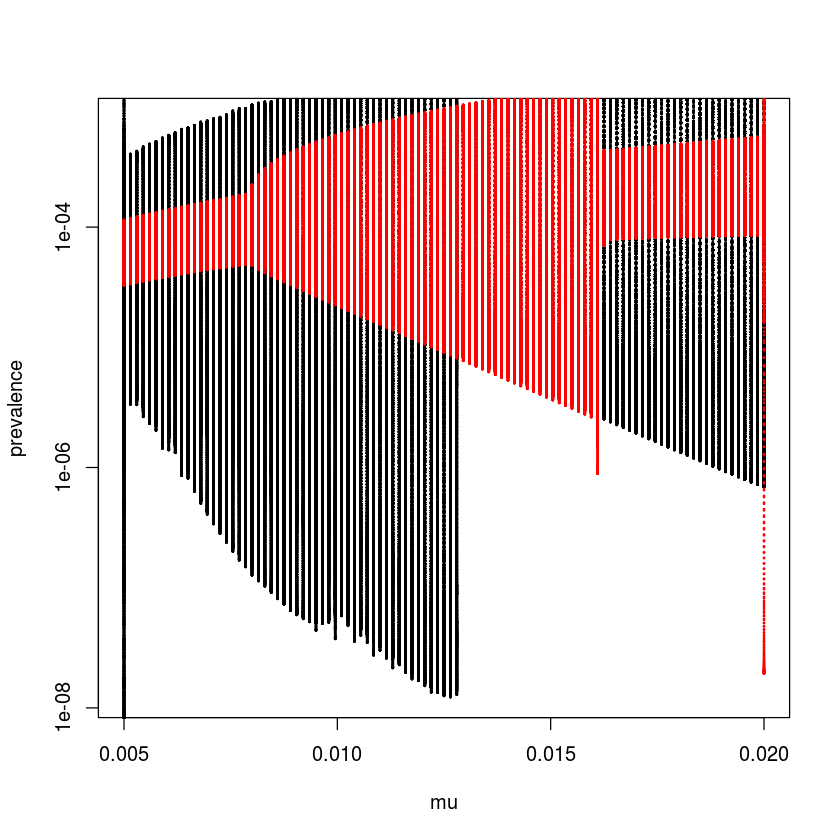

In [16]:
times = seq(0, 100, by = 1/120)
start = c(S = 0.06, E = 0, I = 0.001, R = 0.939)
mu = seq(from = 0.005, to = 0.02, length = 101)
ImatF = ImatB = matrix(NA, ncol = 12001, nrow = 101)
for(i in 1:101){
     paras  = c(mu = mu[i], N = 1, beta0 = 2500, 
          beta1=0.12, sigma = 365/8, gamma = 365/5)
      out = as.data.frame(ode(start, times, seirmod2, 
           paras))
      ImatF[i,] = out$I
      start = c(S = out$S[12001], E = out$E[12001], 
           I = out$I[12001], R = out$R[12001])
}
start = c(S = 0.06, E = 0, I = 0.001, R = 0.939)
for(i in 101:1){
     paras  = c(mu = mu[i], N = 1, beta0 = 2500, 
          beta1 = 0.12, sigma = 365/8, gamma = 365/5)
     out = as.data.frame(ode(start, times, seirmod2, 
          paras))
     ImatB[i,] = out$I
     start = c(S = out$S[12001], E = out$E[12001], 
          I = out$I[12001], R = out$R[12001])
}
sel = seq(7001, 12000, by = 120)
par(mfrow = c(1,1))
     plot(NA, xlim = range(mu),  ylim = range(ImatF[,sel]), 
          log = "y", xlab = "mu", ylab = "prevalence")
for(i in 1:101){
     points(rep(mu[i], dim(ImatF)[2]), ImatF[i, ], 
          pch = 20, cex = 0.25)
     points(rep(mu[i], dim(ImatB)[2]), ImatB[i, ], 
          pch = 20, cex = 0.25, col = 2)
 }